# Evaluate Model
Notebook used for evaluating NNs matching parton jets to gen jets

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import sys

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [3]:
sys.path.append('../src/')
import model

In [4]:
save_dir = '../models/Run_1_2020-11-02/'
assert(os.path.isdir(save_dir))

In [5]:
losses = np.loadtxt(save_dir + 'losses.csv', delimiter=',', skiprows=1)

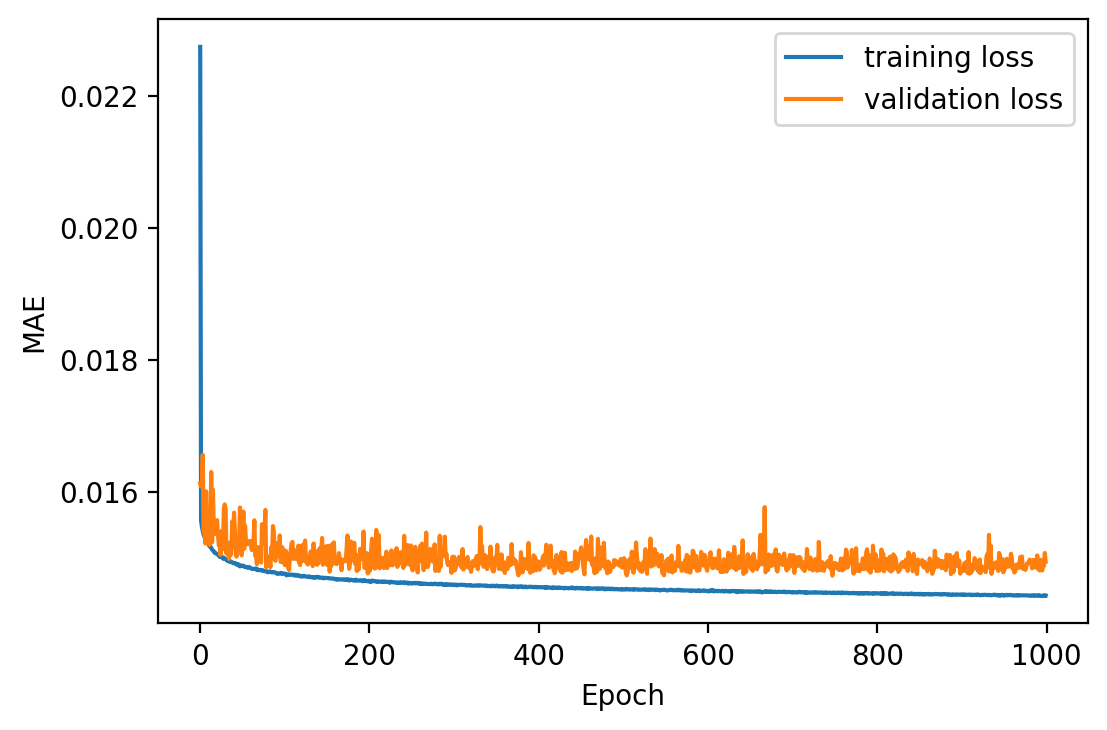

In [6]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(losses[:, 1], label='training loss')
ax.plot(losses[:, 2], label='validation loss')
#ax.set_ylim(0.0075, 0.012)
ax.set_ylabel("MAE")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [1]:
data = np.loadtxt("../data/processed/matchedJets.txt", skiprows=2)

NameError: name 'np' is not defined

In [8]:
print(data.shape)

(185936, 12)


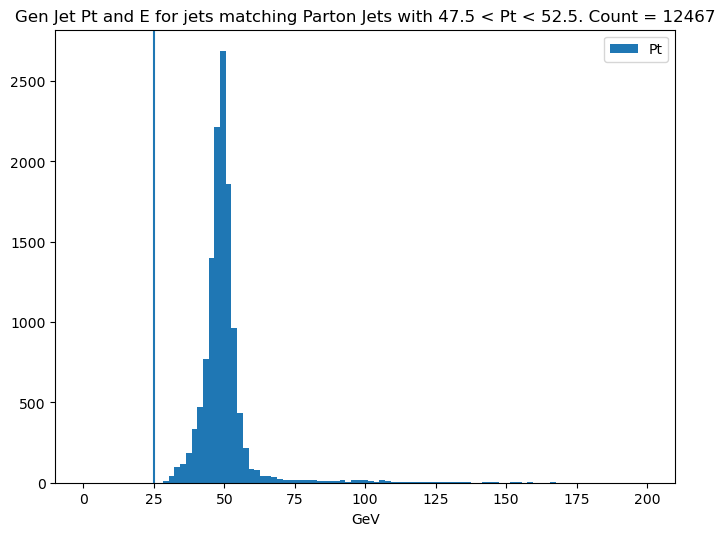

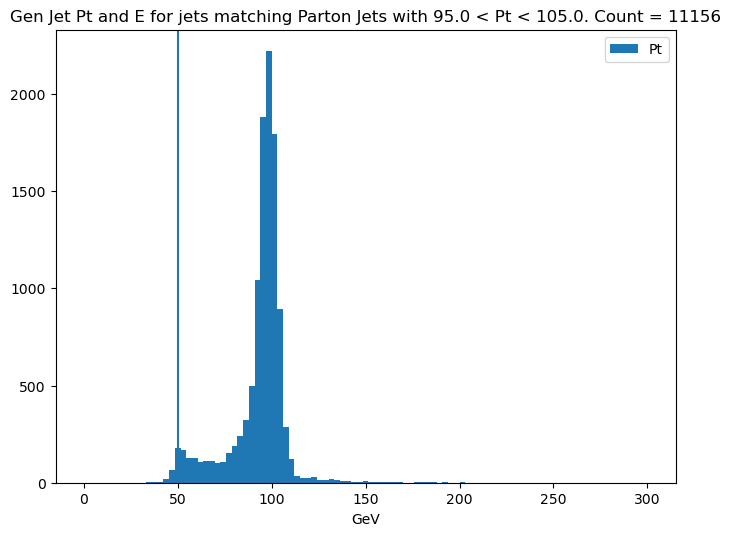

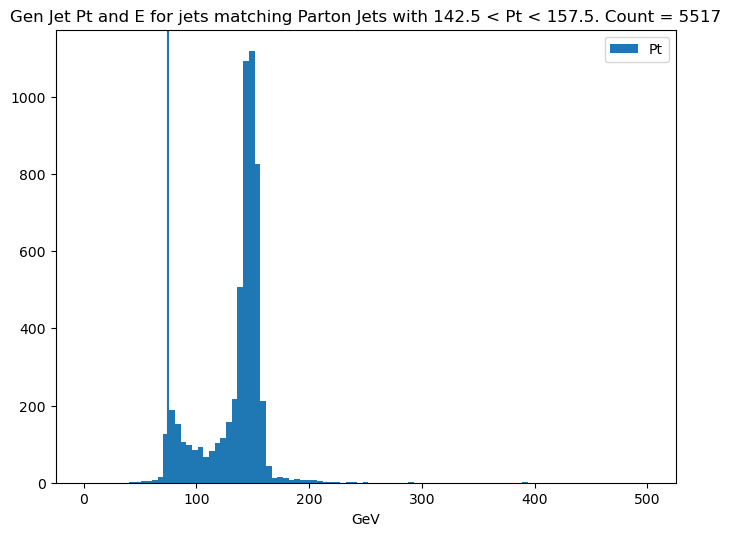

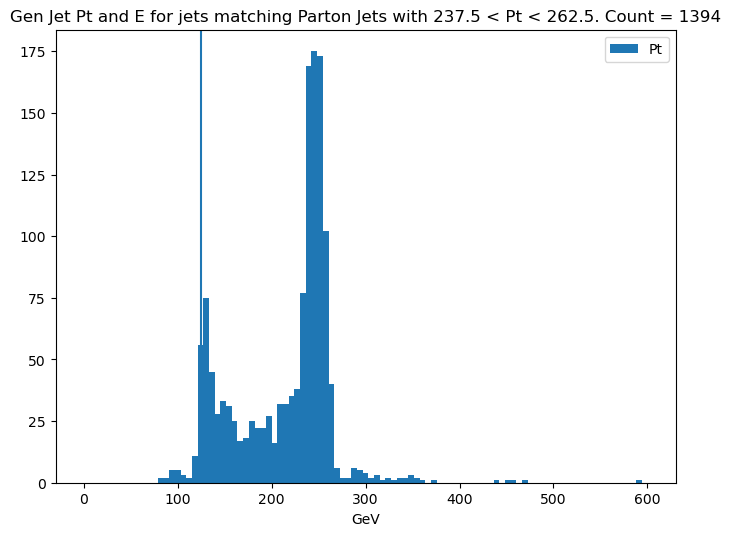

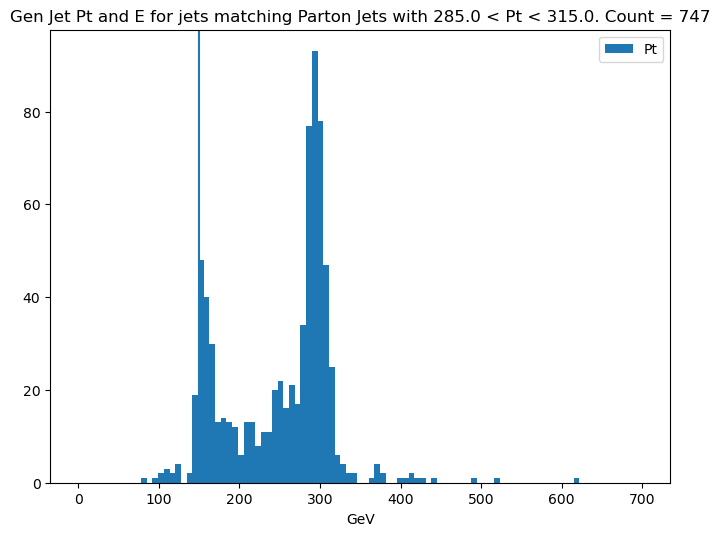

In [13]:
range_highs = [200, 300, 500, 600, 700]
range_lows = [0, 0, 0, 0, 0]
j = 0
for center in [50, 100, 150, 250, 300]:
    pt = []
    energy = []
    low = center - center/20
    high = center + center/20
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            pt.append(data[i, 4])
            energy.append(data[i, 7])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(8,6), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(pt, bins=bins, label='Pt')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_title("Gen Jet Pt and E for jets matching Parton Jets with {} < Pt < {}. Count = {}".format(low, high, len(pt)))
    ax.axvline(x=center/2)

    ax.legend()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.png".format(j))
    j+=1

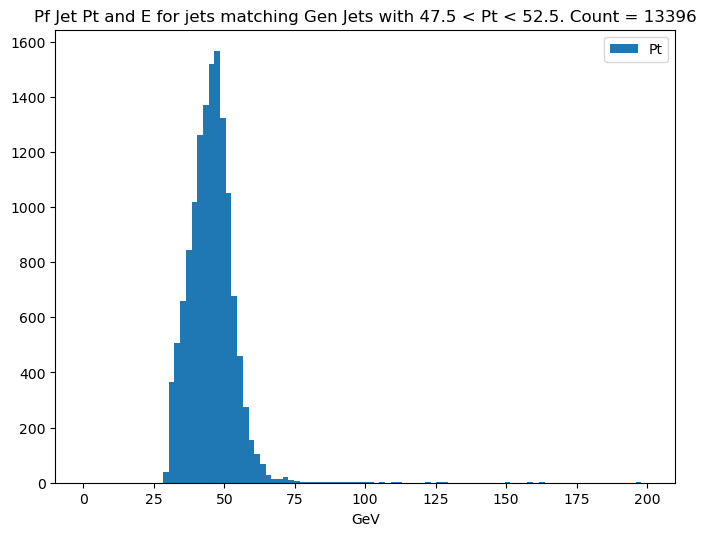

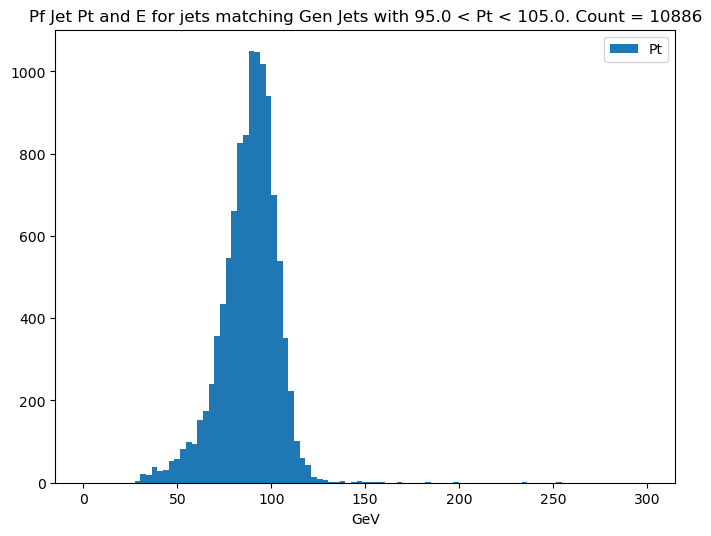

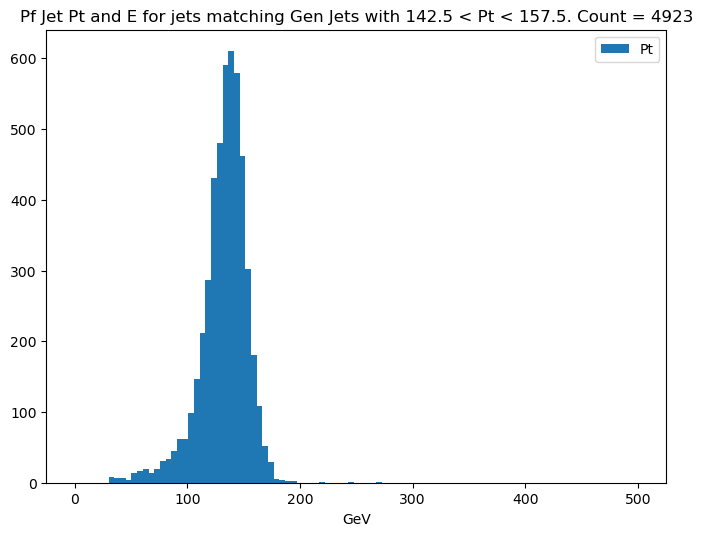

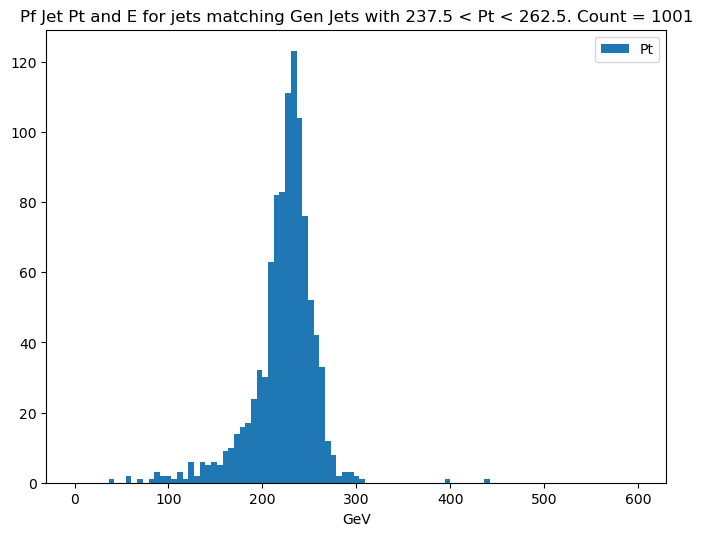

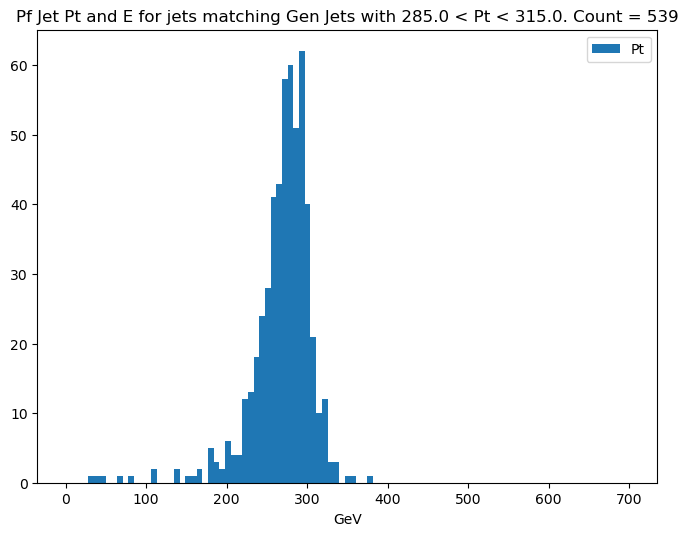

In [10]:
range_highs = [200, 300, 500, 600, 700]
range_lows = [0, 0, 0, 0, 0]
j = 0
for center in [50, 100, 150, 250, 300]:
    pt = []
    energy = []
    low = center - center/20
    high = center + center/20
    for i in range(len(data)):
        if (data[i, 4] > low and data[i, 4] < high):
            pt.append(data[i, 8])
            energy.append(data[i, 11])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(8,6), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(pt, bins=bins, label='Pt')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_title("Pf Jet Pt and E for jets matching Gen Jets with {} < Pt < {}. Count = {}".format(low, high, len(pt)))
    ax.legend()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.png".format(j))
    j+=1

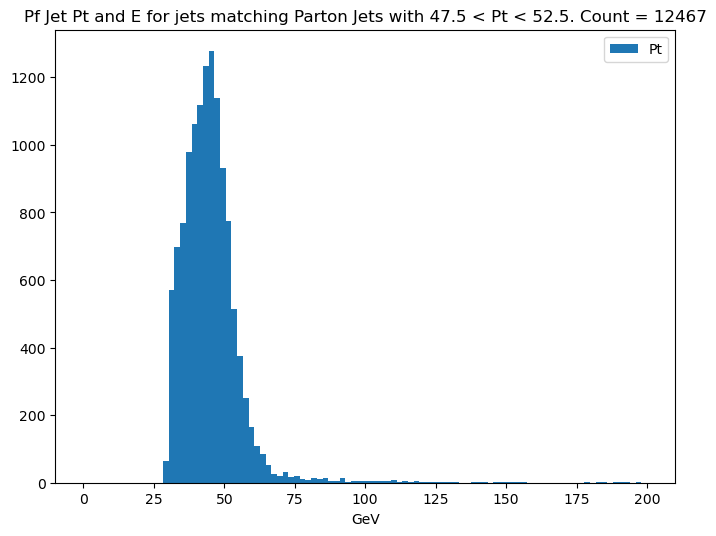

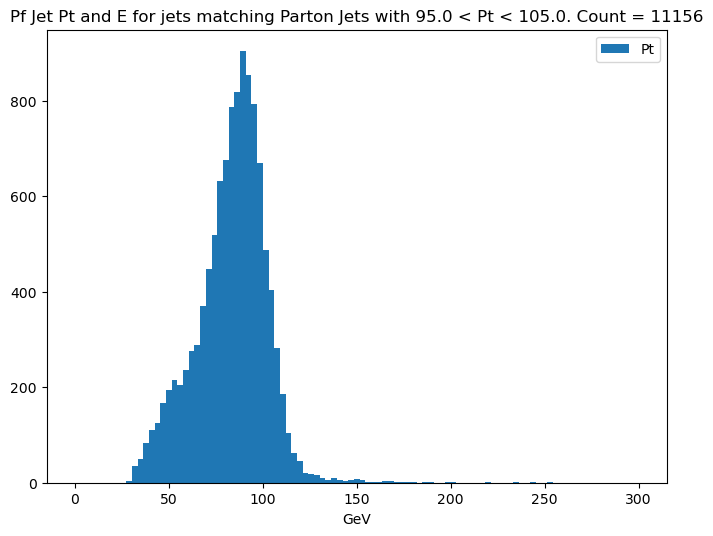

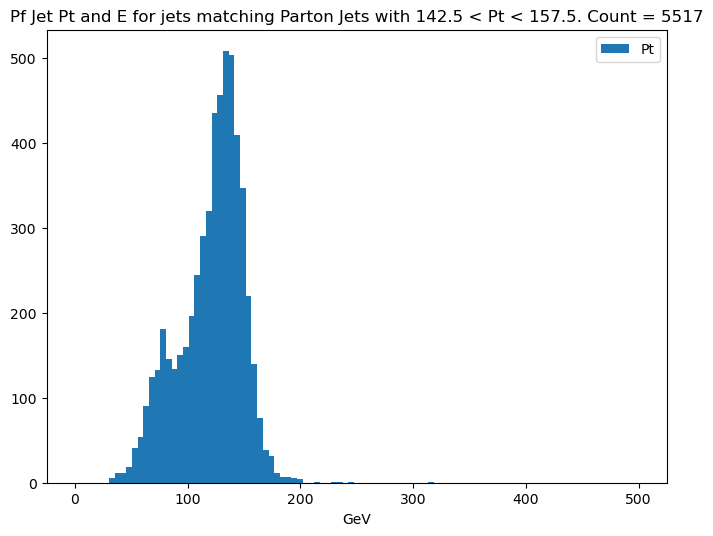

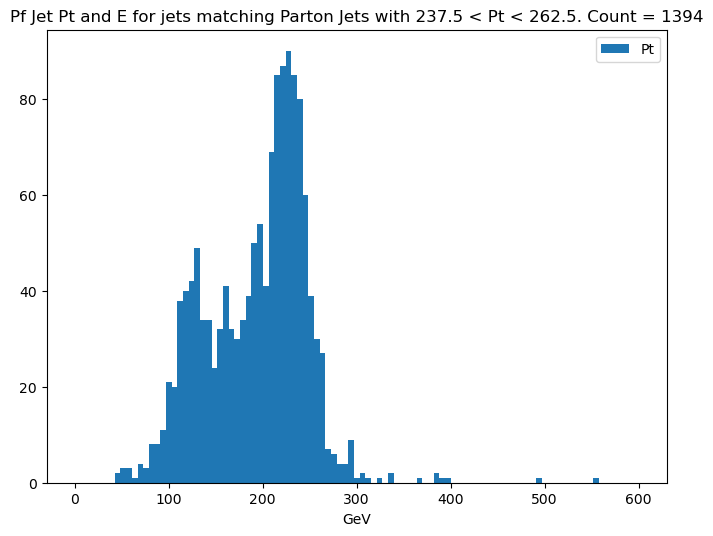

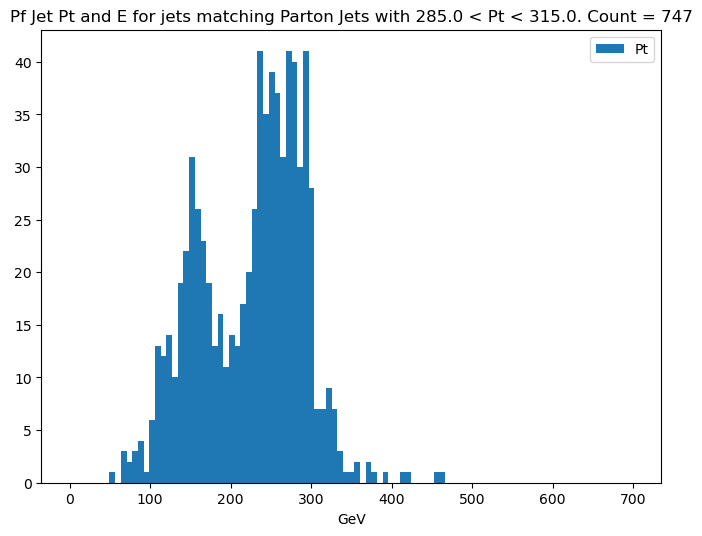

In [40]:
range_highs = [200, 300, 500, 600, 700]
range_lows = [0, 0, 0, 0, 0]
j = 0
for center in [50, 100, 150, 250, 300]:
    pt = []
    energy = []
    low = center - center/20
    high = center + center/20
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            pt.append(data[i, 8])
            energy.append(data[i, 11])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(8,6), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(pt, bins=bins, label='Pt')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_title("Pf Jet Pt and E for jets matching Parton Jets with {} < Pt < {}. Count = {}".format(low, high, len(pt)))
    ax.legend()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.png".format(j))
    j+=1

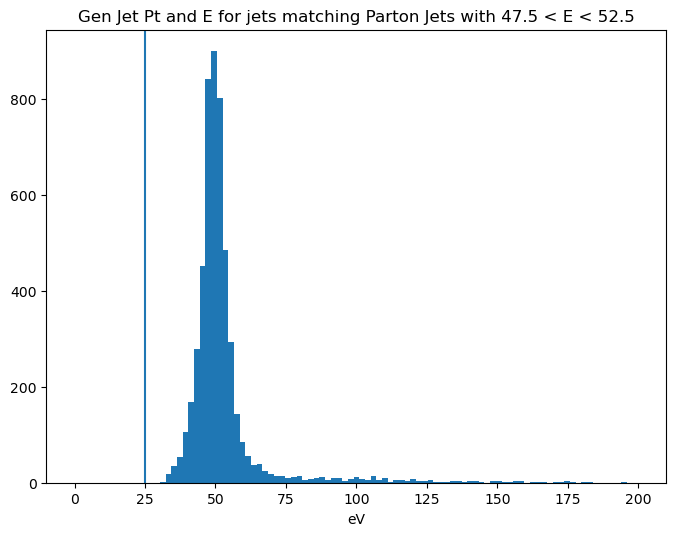

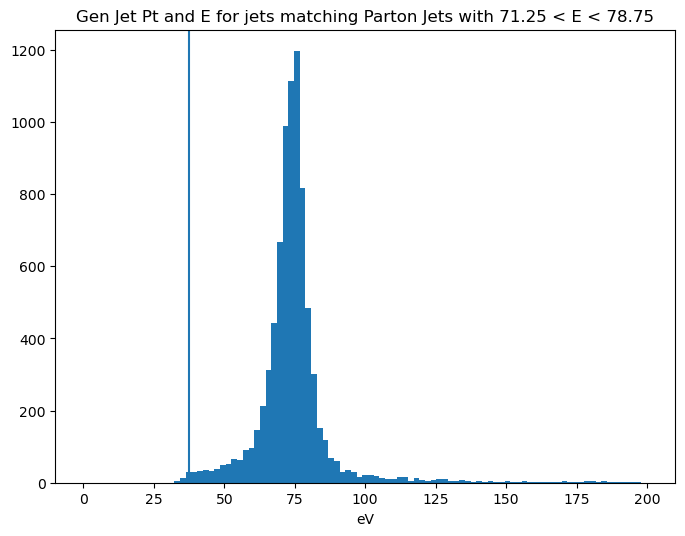

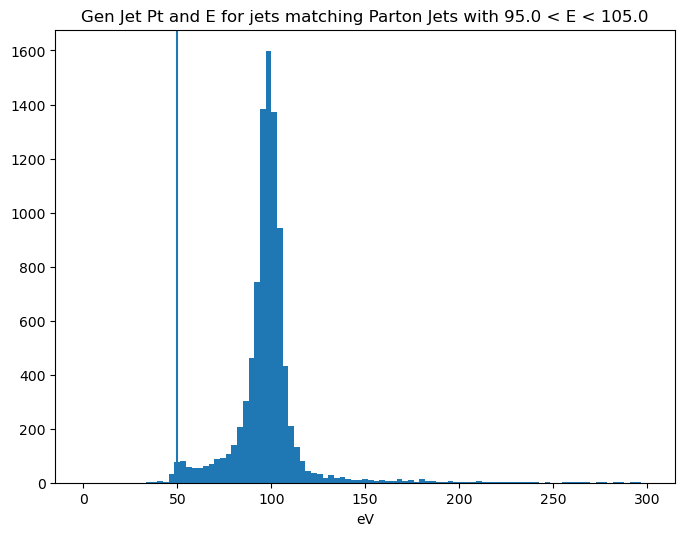

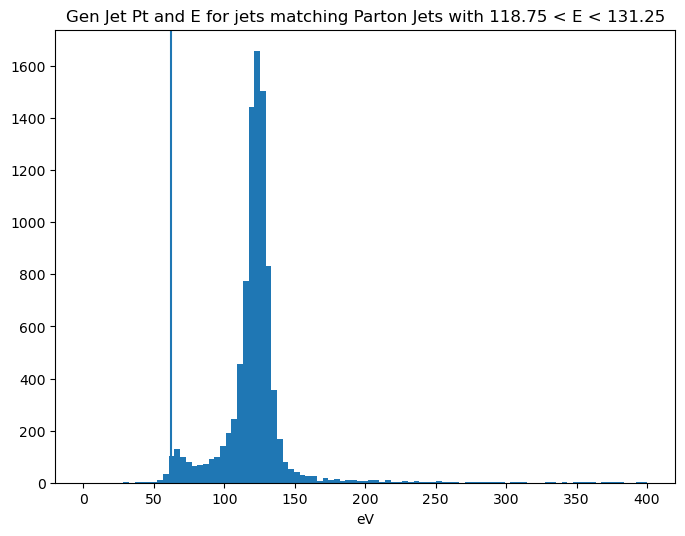

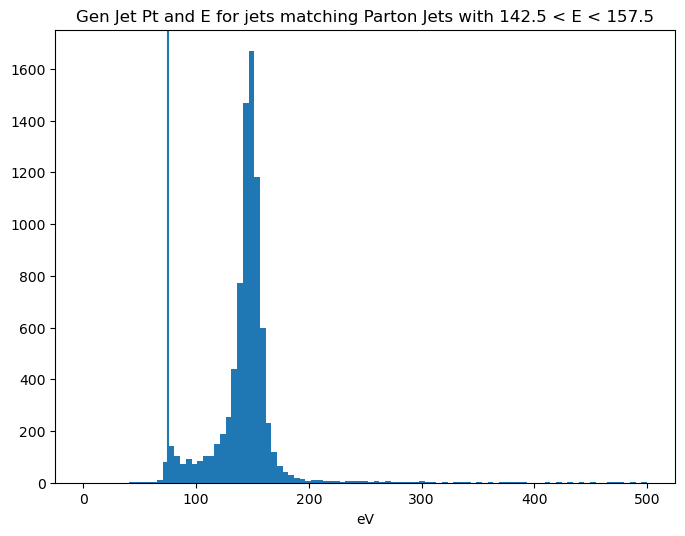

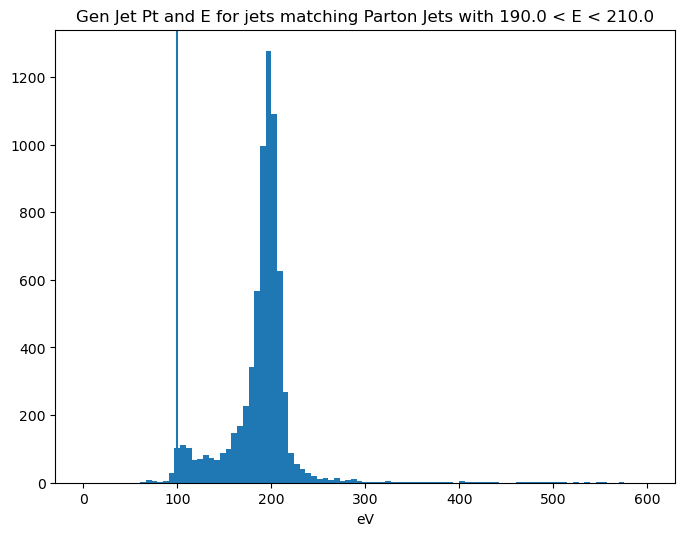

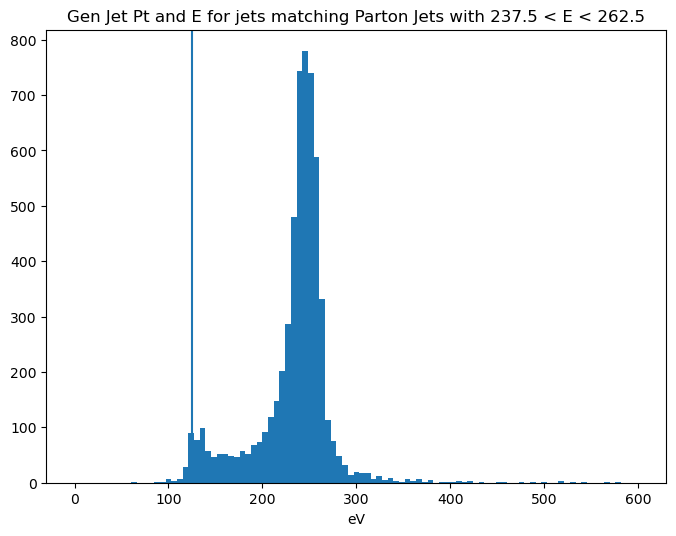

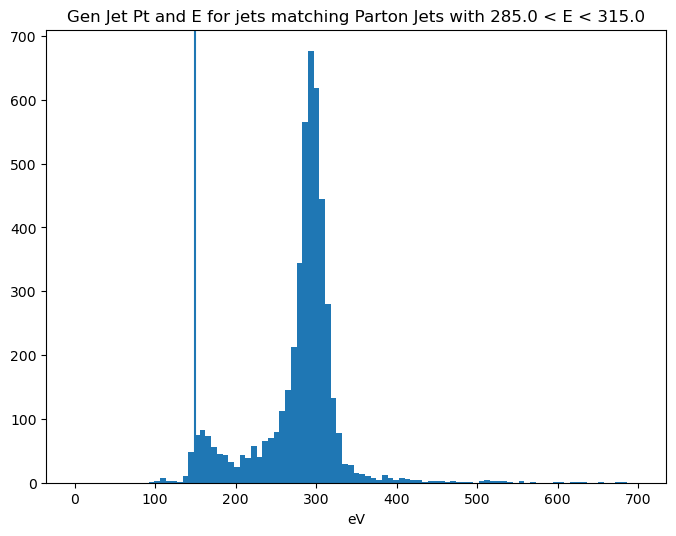

In [12]:
range_highs = [200, 200, 300, 400, 500, 600, 600, 700]
range_lows = [0, 0, 0, 0, 0, 0, 0, 0]
j = 0
for center in [50, 75, 100, 125, 150, 200, 250, 300]:
    pt = []
    energy = []
    low = center - center/20
    high = center + center/20
    for i in range(len(data)):
        if (data[i, 3] > low and data[i, 3] < high):
            pt.append(data[i, 4])
            energy.append(data[i, 7])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(8,6), dpi=100)
    ax = fig.add_subplot(111)
    #ax.hist(pt, bins=bins, label='Pt')
    ax.hist(energy, bins=bins, label='E')
    ax.axvline(x=center/2)
    ax.set_xlabel("eV")
    ax.set_title("Gen Jet Pt and E for jets matching Parton Jets with {} < E < {}".format(low, high))
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.png".format(j))
    j+=1

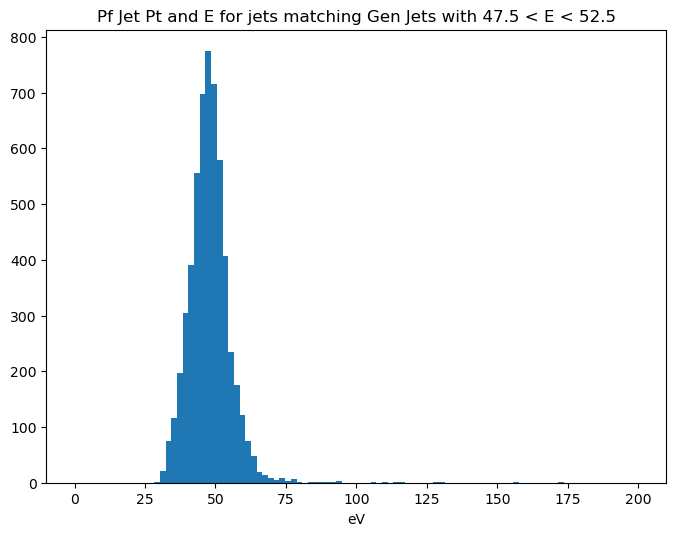

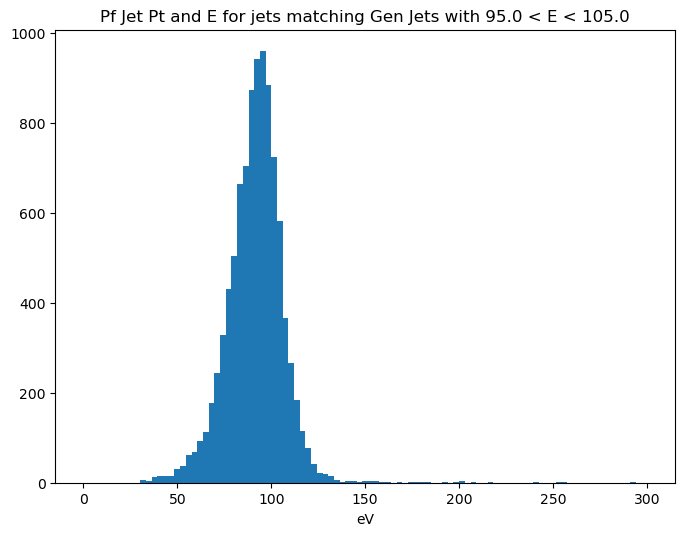

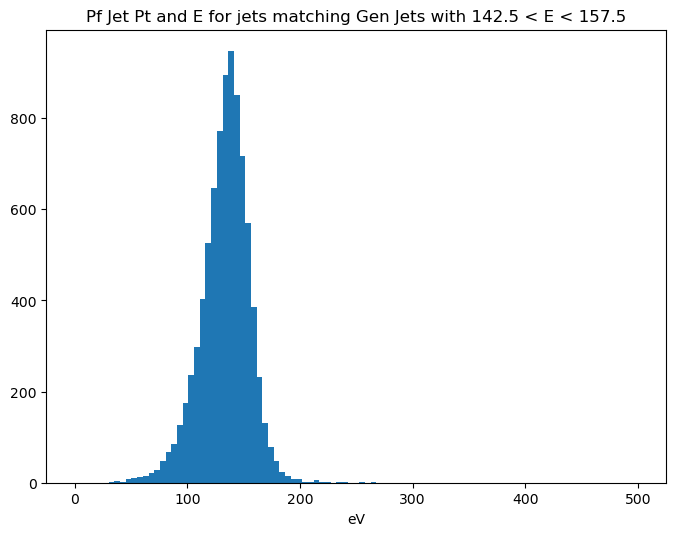

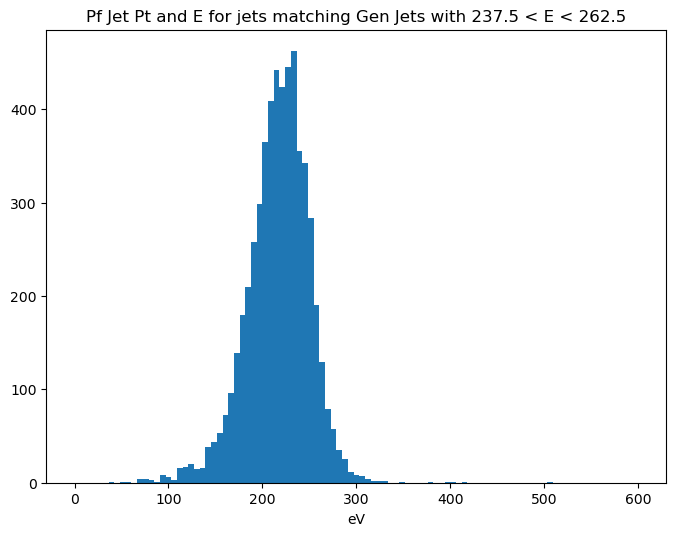

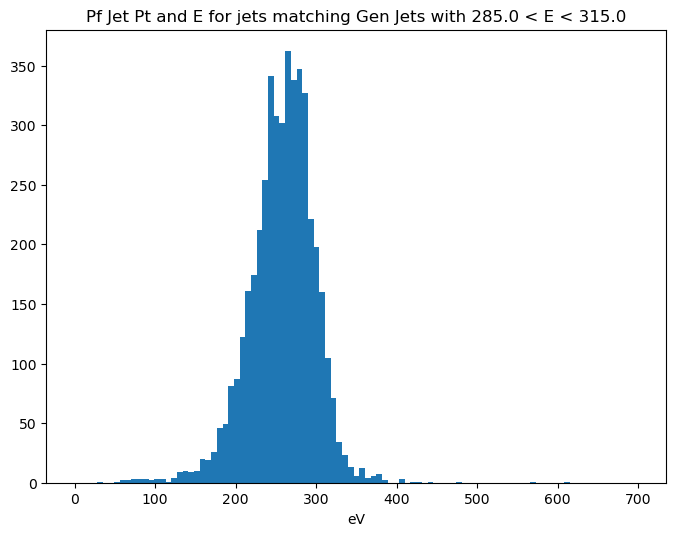

In [41]:
range_highs = [200, 300, 500, 600, 700]
range_lows = [0, 0, 0, 0, 0]
j = 0
for center in [50, 100, 150, 250, 300]:
    pt = []
    energy = []
    low = center - center/20
    high = center + center/20
    for i in range(len(data)):
        if (data[i, 7] > low and data[i, 7] < high):
            pt.append(data[i, 4])
            energy.append(data[i, 11])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(8,6), dpi=100)
    ax = fig.add_subplot(111)
    #ax.hist(pt, bins=bins, label='Pt')
    ax.hist(energy, bins=bins, label='E')
    ax.set_xlabel("eV")
    ax.set_title("Pf Jet Pt and E for jets matching Gen Jets with {} < E < {}".format(low, high))
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.png".format(j))
    j+=1

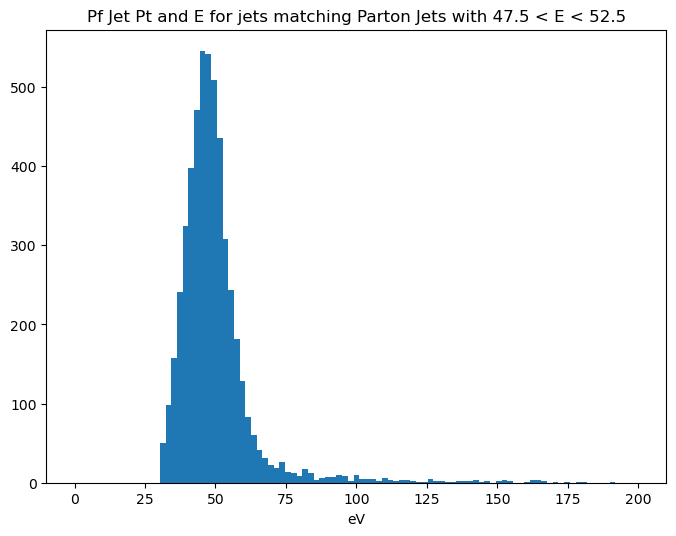

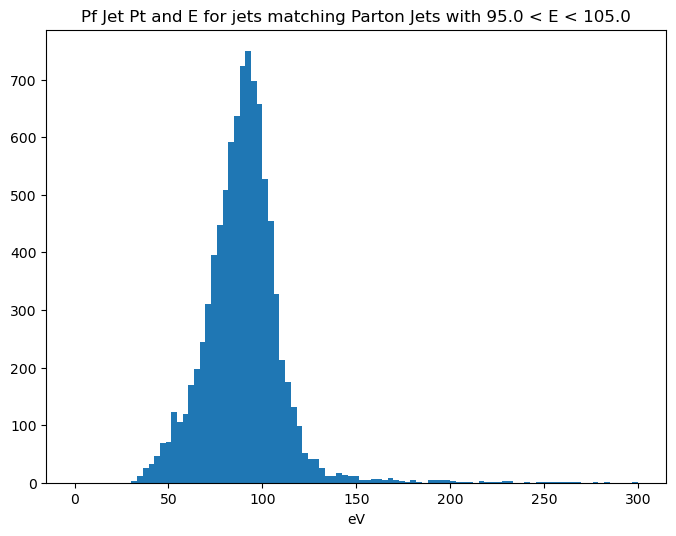

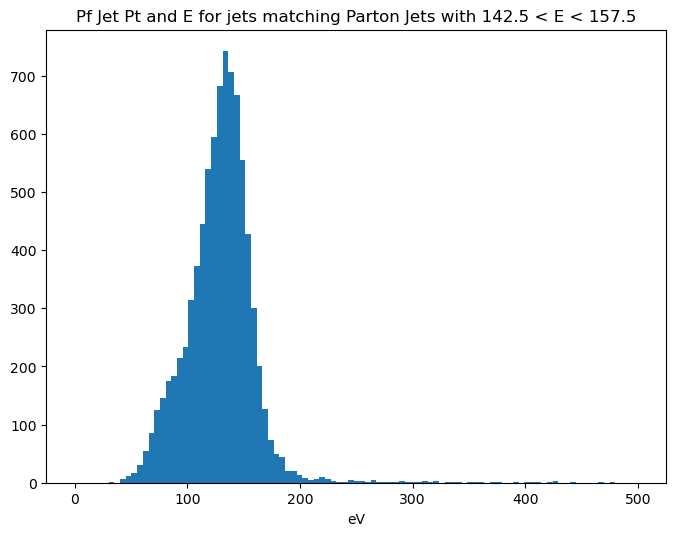

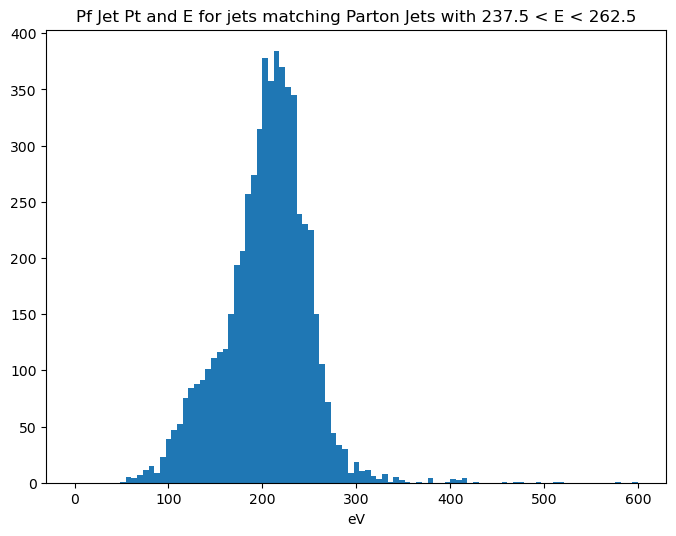

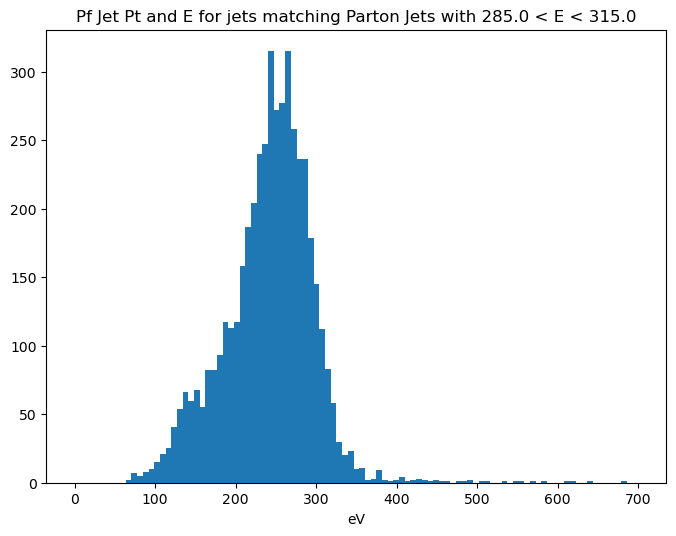

In [42]:
range_highs = [200, 300, 500, 600, 700]
range_lows = [0, 0, 0, 0, 0]
j = 0
for center in [50, 100, 150, 250, 300]:
    pt = []
    energy = []
    low = center - center/20
    high = center + center/20
    for i in range(len(data)):
        if (data[i, 3] > low and data[i, 3] < high):
            pt.append(data[i, 4])
            energy.append(data[i, 11])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(8,6), dpi=100)
    ax = fig.add_subplot(111)
    #ax.hist(pt, bins=bins, label='Pt')
    ax.hist(energy, bins=bins, label='E')
    ax.set_xlabel("eV")
    ax.set_title("Pf Jet Pt and E for jets matching Parton Jets with {} < E < {}".format(low, high))
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.png".format(j))
    j+=1

In [24]:

print(data[0])
partonPtMax = np.max(data[:, 0], axis=0)
partonPtMin = np.min(data[:, 0], axis=0)
partonMean = np.mean(data[:, 1:3], axis=0)
partonStd = np.std(data[:, 1:3], axis=0)
partonEMax = np.max(data[:, 3], axis=0)
partonEMin = np.min(data[:, 3], axis=0)

genPtMax = np.max(data[:, 4], axis=0)
genPtMin = np.min(data[:, 4], axis=0)
genMean = np.mean(data[:, 5:7], axis=0)
genStd = np.std(data[:, 5:7], axis=0)
genEMax = np.max(data[:, 7], axis=0)
genEMin = np.min(data[:, 7], axis=0)

data[:, 0] = (data[:, 0] - partonPtMin)/partonPtMax
data[:, 1:3] = (data[:, 1:3] - partonMean)/partonStd
data[:, 3] = (data[:, 3] - partonEMin)/partonEMax
data[:, 4] = (data[:, 4] - genPtMin)/genPtMax
data[:, 5:7] = (data[:, 5:7] - genMean)/genStd
data[:, 7] = (data[:, 7] - genEMin)/genEMax
print(data[0])

[41.4024   -1.27316  -0.891338 80.6118   36.3716   -1.24909  -0.87713
 69.0265  ]
[ 0.01378033 -0.89004362 -0.49111903  0.00580332  0.00464446 -0.8708328
 -0.48343232  0.00806188]


In [25]:
#print(tf.config.list_physical_devices())
devices = tf.config.list_physical_devices()
print(len(devices[0]))

2


In [26]:
with tf.device('/CPU:0'):
    index = int(0.8*len(data))
    validate = data[index:, :]
    validateParton = validate[:, :4]
    validateInputs = validate[:, :4]
    validateGen = validate[:, 4:]
    mae = keras.losses.MeanAbsoluteError()
    naiveErr = mae(validateParton, validateGen).numpy()
    print(naiveErr)

0.017238086089491844


In [27]:
checkpoint_path = save_dir + 'training/cp.cpkt'
with tf.device('/CPU:0'):
    net = model.make_model()
    net.summary()
    mse = keras.losses.MeanSquaredError()
    net.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
           loss=mse,
           metrics=[keras.metrics.MeanAbsoluteError()])
    net.load_weights(checkpoint_path)
    prediction = net.predict(validateInputs)
    net.evaluate(validateInputs, validateGen, batch_size=128)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 67,204
Trainable params: 67,204
Non-trainable params: 0
__________________________________________________

In [28]:
mae = keras.losses.MeanAbsoluteError()

print(validate[0, 0])
validate[:, 0] = (validate[:, 0])*partonPtMax + partonPtMin
validate[:, 1:3] = (validate[:, 1:3])*partonStd + partonMean
validate[:, 3] = (validate[:, 3])*partonEMax + partonEMin

validate[:, 4] = (validate[:, 4])*genPtMax + genPtMin
validate[:, 5:7] = (validate[:, 5:7])*genStd + genMean
validate[:, 7] = (validate[:, 7])*genEMax + genEMin

inputs = validate[:, :4]

print(prediction[0, 0])
prediction[:, 0] = (prediction[:, 0])*genPtMax + genPtMin
prediction[:, 1:3] = prediction[:, 1:3]*genStd + genMean
prediction[:, 3] = (prediction[:, 3])*genEMax + genEMin
true = validate[:, 4:]
print(prediction[0, 0])


0.021915342961451045
0.0133302305
48.287178


In [29]:
print(prediction[0])
print(true[0])

[48.287178  -1.328972  -0.5046229 97.2825   ]
[45.6982   -1.35546  -0.452973 94.6302  ]


In [30]:
with tf.device('/CPU:0'):    
    #calculate MAEs between components of parton and gen jets
    naivePxErr = mae(inputs[:, 0], true[:, 0]).numpy()
    print(naivePxErr)
    naivePyErr = mae(inputs[:, 1], true[:, 1]).numpy()
    print(naivePyErr)
    naivePzErr = mae(inputs[:, 2], true[:, 2]).numpy()
    print(naivePzErr)
    naiveEErr = mae(inputs[:, 3], true[:, 3]).numpy()
    print(naiveEErr)
    #naivePtErr = mae(np.sqrt((inputs[:, 0])**2 + (inputs[:, 1]**2)), np.sqrt((true[:, 0])**2 + (true[:, 1]**2))).numpy()
    #print(naivePtErr)

17.868562698364258
0.023718006908893585
0.04667610302567482
49.08238983154297


In [31]:
#calculate MAEs between components of predicted and gen jets
predPxErr = mae(prediction[:, 0], true[:, 0]).numpy()
print(predPxErr)
predPyErr = mae(prediction[:, 1], true[:, 1]).numpy()
print(predPyErr)
predPzErr = mae(prediction[:, 2], true[:, 2]).numpy()
print(predPzErr)
predEErr = mae(prediction[:, 3], true[:, 3]).numpy()
print(predEErr)
predPtErr = mae(np.sqrt((prediction[:, 0])**2 + (prediction[:, 1]**2)), np.sqrt((true[:, 0])**2 + (true[:, 1]**2))).numpy()
print(predPtErr)

13.047805786132812
0.023254474624991417
0.04694966599345207
32.11148452758789
13.044703483581543


In [32]:
pt_err_close = []
pt_err_far = []
pt_pred_close = []
pt_true_close = []
pt_pred_far = []
pt_true_far = []
for i in range(len(prediction)):
    if (((inputs[i, 1] - true[i, 1])**2 + (inputs[i, 2] - inputs[i, 2])**2)**(1/2) < 0.01):
        pt_err_close.append(abs(prediction[i, 0] - true[i, 0]))
        pt_true_close.append(true[i, 0])
        pt_pred_close.append(prediction[i, 0])
    else:
        pt_err_far.append(abs(prediction[i, 0] - true[i, 0]))
        pt_true_far.append(true[i, 0])
        pt_pred_far.append(prediction[i, 0])
    

In [33]:
print(np.mean(pt_err_close))
print(np.mean(pt_err_far))

13.656383643466476
12.664096586778781


In [34]:
ratio_close = np.array(pt_pred_close)/np.array(pt_true_close)
ratio_far = np.array(pt_pred_far)/np.array(pt_true_far)

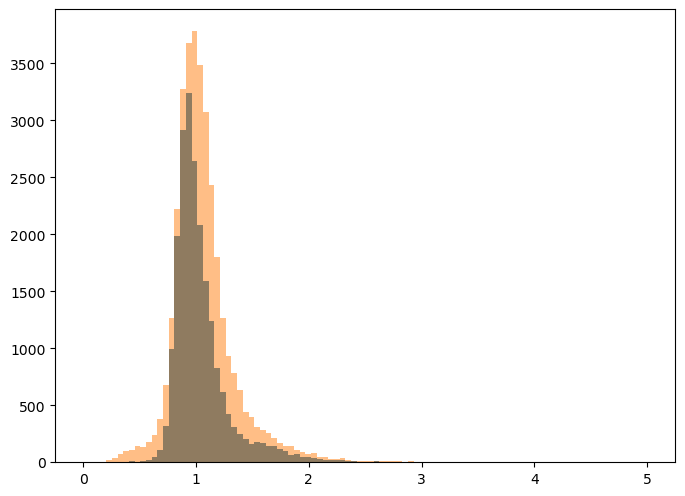

In [35]:
bins = np.linspace(0, 5, 100)
fig = plt.figure(figsize=(8,6), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(ratio_close, bins=bins)
ax1.hist(ratio_far, bins=bins, alpha=0.5)
plt.show()

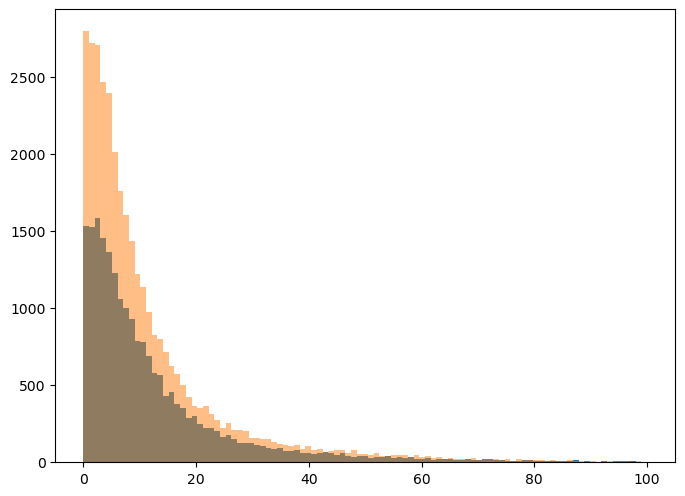

In [36]:
bins = np.linspace(0, 100, 100)
fig = plt.figure(figsize=(8,6), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(pt_err_close, bins=bins)
ax1.hist(pt_err_far, bins=bins, alpha=0.5)
plt.show()

In [37]:
percent_errs = abs((inputs - true)/true * 100)
print(np.mean(percent_errs, axis=0))
percent_errs = abs((prediction - true)/true * 100)
print(np.mean(percent_errs, axis=0))

[26.39152744 10.98862228 10.70754164 26.46637746]
[18.10524917 10.9006467  11.77913648 18.37330279]


In [38]:
px_err_parts = []
py_err_parts = []
pz_err_parts = []
E_err_parts = []
px_err_preds = []
py_err_preds = []
pz_err_preds = []
E_err_preds = []

px_mae_parts = []
py_mae_parts = []
pz_mae_parts = []
E_mae_parts = []
px_mae_preds = []
py_mae_preds = []
pz_mae_preds = []
E_mae_preds = []
true_pt = (np.sqrt((true[:, 0])**2 + (true[:, 1])**2))
for i in range(len(true)):
    if true_pt[i] > 0:
        px_err_parts.append(abs((inputs[i, 0] - true[i, 0])/true[i, 0])*100)
        py_err_parts.append(abs((inputs[i, 1] - true[i, 1])/true[i, 1])*100)
        pz_err_parts.append(abs((inputs[i, 2] - true[i, 2])/true[i, 2])*100)
        E_err_parts.append(abs((inputs[i, 3] - true[i, 3])/true[i, 3])*100)
        
        px_err_preds.append(abs((prediction[i, 0] - true[i, 0])/true[i, 0])*100)
        py_err_preds.append(abs((prediction[i, 1] - true[i, 1])/true[i, 1])*100)
        pz_err_preds.append(abs((prediction[i, 2] - true[i, 2])/true[i, 2])*100)
        E_err_preds.append(abs((prediction[i, 3] - true[i, 3])/true[i, 3])*100)
        
        px_mae_parts.append(abs(inputs[i, 0] - true[i, 0]))
        py_mae_parts.append(abs(inputs[i, 1] - true[i, 1]))
        pz_mae_parts.append(abs(inputs[i, 2] - true[i, 2]))
        E_mae_parts.append(abs(inputs[i, 3] - true[i, 3]))
        
        px_mae_preds.append(abs(prediction[i, 0] - true[i, 0]))
        py_mae_preds.append(abs(prediction[i, 1] - true[i, 1]))
        pz_mae_preds.append(abs(prediction[i, 2] - true[i, 2]))
        E_mae_preds.append(abs(prediction[i, 3] - true[i, 3]))
        
print(np.mean(px_err_parts))
print(np.mean(py_err_parts))
print(np.mean(pz_err_parts))
print(np.mean(E_err_parts))
print()

print(np.mean(px_err_preds))
print(np.mean(py_err_preds))
print(np.mean(pz_err_preds))
print(np.mean(E_err_preds))
print()

print(np.mean(px_mae_parts))
print(np.mean(py_mae_parts))
print(np.mean(pz_mae_parts))
print(np.mean(E_mae_parts))
print()

print(np.mean(px_mae_preds))
print(np.mean(py_mae_preds))
print(np.mean(pz_mae_preds))
print(np.mean(E_mae_preds))
        
        

26.391527436384095
10.9886222792323
10.707541644555096
26.466377458192753

18.105249165594742
10.900646703828635
11.779136483386935
18.373302790941217

17.86856301623624
0.023718006855027784
0.046676104713902954
49.082388783553085

13.04780542428912
0.02325447500293175
0.04694966696965819
32.111482955102474


## Histograms of Pt

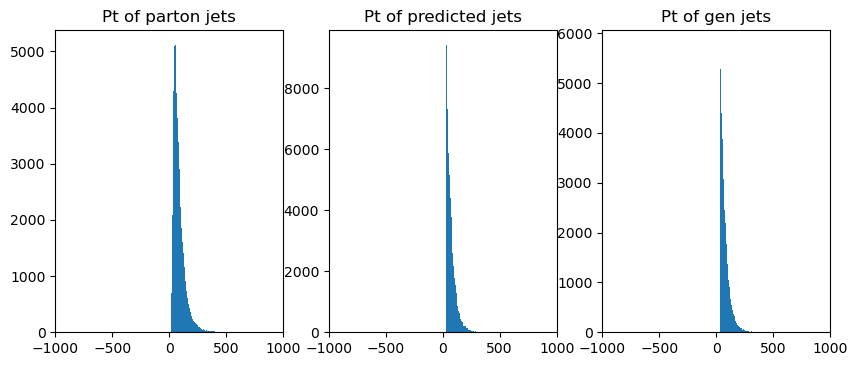

In [39]:
fig = plt.figure(figsize=(10,4), dpi=100)
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 0], bins=200)
ax1.set_title("Pt of parton jets")
ax1.set_xlim(-1000, 1000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 0], bins=200)
ax2.set_title("Pt of predicted jets")
ax2.set_xlim(-1000, 1000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 0], bins=200)
ax3.set_title("Pt of gen jets")
ax3.set_xlim(-1000, 1000)
#plt.yscale('log')
plt.show()

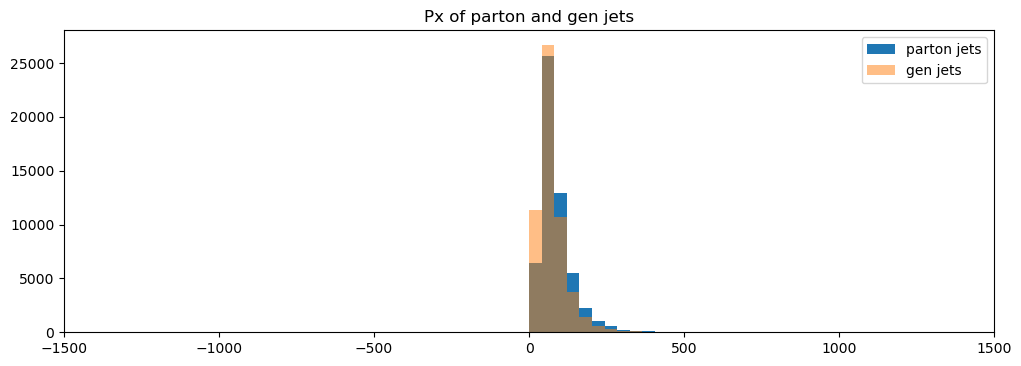

In [40]:
bins = np.linspace(-1500, 1500, 75)
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 0], bins=bins, label='parton jets')
ax1.hist(true[:, 0], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Px of parton and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

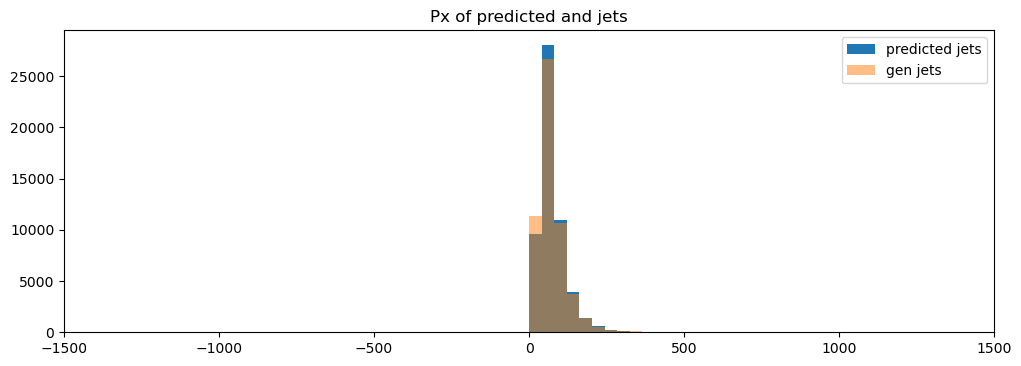

In [41]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 0], bins=bins, label='predicted jets')
ax1.hist(true[:, 0], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Px of predicted and jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

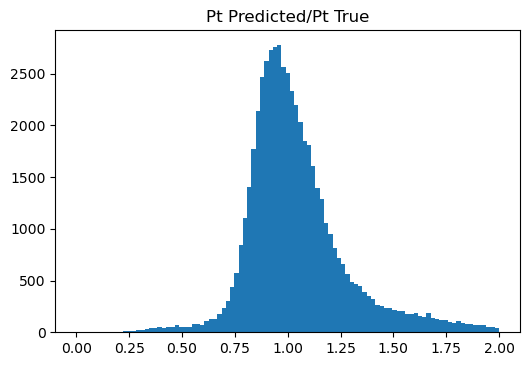

In [42]:
bins = np.linspace(0.0, 2, 100)
fig = plt.figure(figsize=(6,4), dpi=100)
ax1 = fig.add_subplot(111)
ratios = prediction[:, 0] / true[:, 0]
ax1.hist(ratios, bins=bins)
ax1.set_title("Pt Predicted/Pt True")
plt.show()

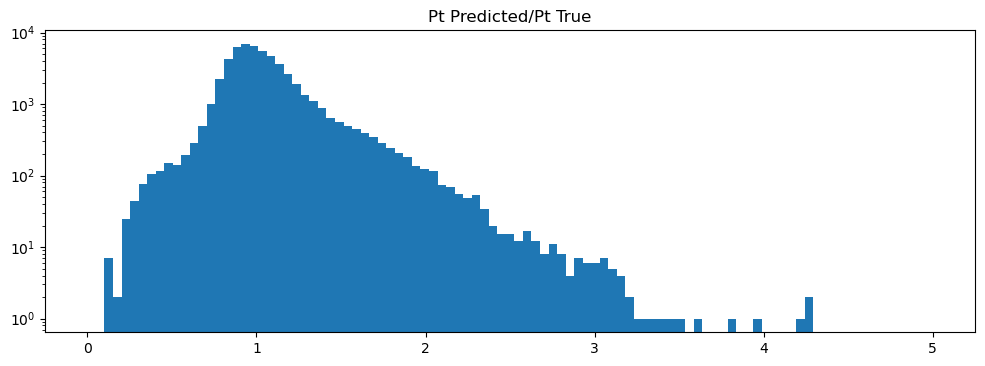

In [43]:
bins = np.linspace(0.0, 5, 100)
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ratios = prediction[:, 0] / true[:, 0]
ax1.hist(ratios, bins=bins)
ax1.set_title("Pt Predicted/Pt True")
ax1.set_yscale('log')
plt.show()

Text(0, 0.5, 'Pred Pt/True Pt')

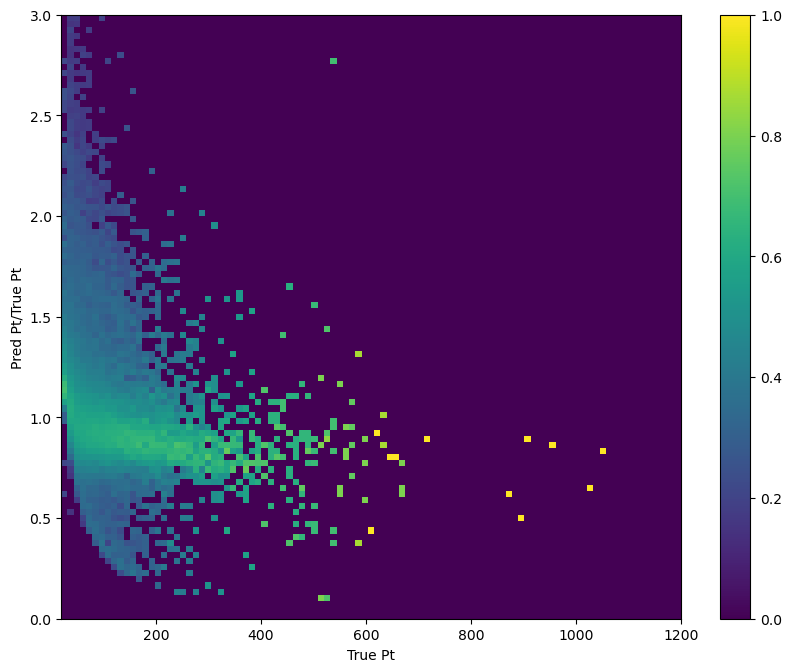

In [44]:
#bins1 = np.linspace(0.0, 5, 100)
#bins2 = np.linspace(0, 1000, 100)
fig = plt.figure(figsize=(10,8), dpi=100)
ax1 = fig.add_subplot(111)
ratios = prediction[:, 0] / true[:, 0]
ratio_bins = np.linspace(0, 3.0, 100)
pt_bins = np.linspace(20, 1200, 100)
h2, xbins, ybins = np.histogram2d(true[:, 0], ratios, bins=(pt_bins, ratio_bins))

for i in range(len(h2)):
    if (sum(h2[i]) > 0):
        h2[i] /= sum(h2[i])
        h2[i] = (h2[i])**(1/5)
h2 = np.transpose(h2)
plt.imshow(h2, origin='lower', extent=[20, 1200, 0, 3.0], aspect='auto')
#plt.ylim(0, 3)
plt.colorbar()
plt.xlabel("True Pt")
plt.ylabel("Pred Pt/True Pt")
#print(h2[8])
#print(sum(h2[2]))
#print(h2[:, 4])
#h = ax1.hist2d(true[:, 0], ratios, bins=100, norm=mpl.colors.PowerNorm(0.15))
#ax1.hist2d(true[:, 0], ratios, bins=100)
#ax1.hist(true[:, 0])
#h = ax1.hist2d(ratios, true[:, 0], bins=100, norm=mpl.colors.Normalize())
#ax1.set_ylim(0.1, 3)
#ax1.set_xlim(30, 1000)
#ax1.set_ylabel("Predicted Pt / True Pt")
#ax1.set_xlabel("True Pt")
#ax1.set_title("Pt Predicted/Pt True")
#ax1.set_yscale('log')
#plt.colorbar(h[3], ax=ax1, ticks=(0, 5, 10, 50, 100, 500, 1000, 3000))
#plt.show()

44.03885
44.437485
45.367245536215606
44.146847


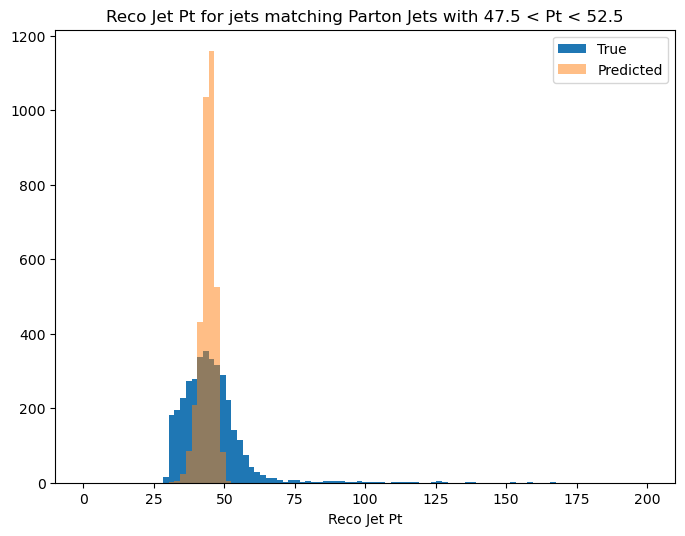

127.24600000000001
126.280975
121.52866484375
125.74649


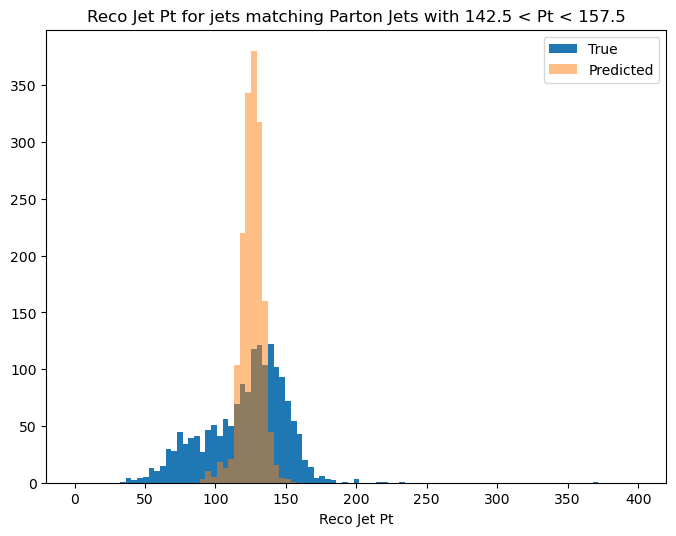

199.098
200.61044
190.73799501246884
201.20659


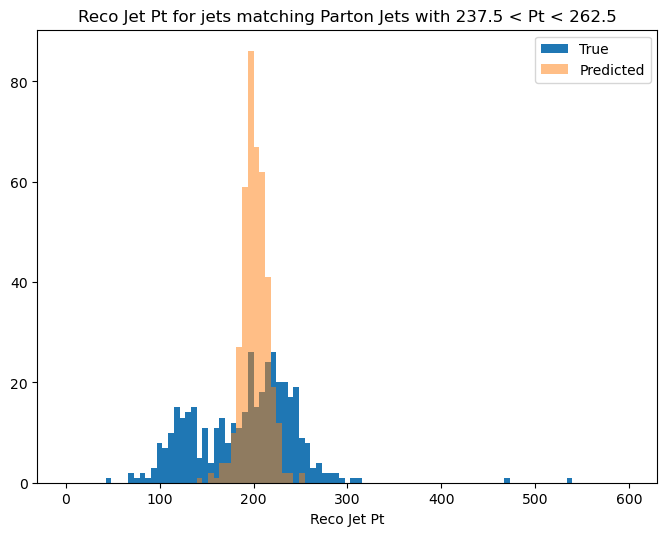

239.865
232.21133
227.31389609756093
232.88164


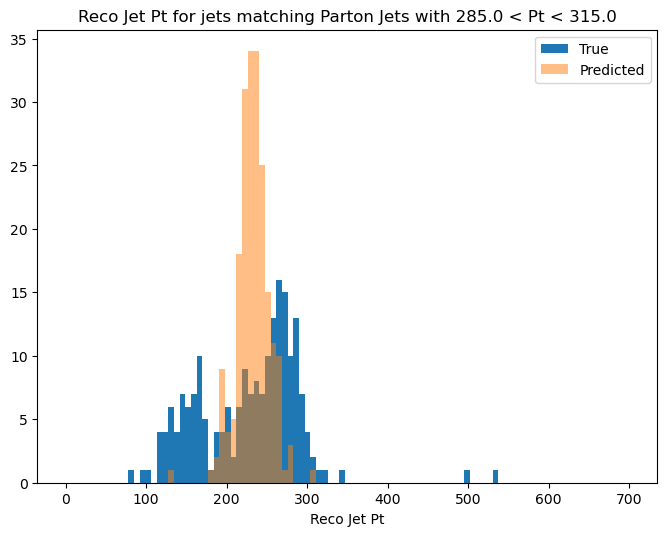

In [46]:
range_highs = [200, 400, 600, 700]
range_lows = [0, 0, 0, 0]
j = 0
for center in [50, 150, 250, 300]:
    pt_true = []
    pt_predicted = []
    low = center - center/20
    high = center + center/20
    for i in range(len(validate)):
        if (validate[i, 0] > low and validate[i, 0] < high):
            pt_true.append(validate[i, 4])
            pt_predicted.append(prediction[i, 0])
    print(np.median(pt_true))
    print(np.median(pt_predicted))
    print(np.mean(pt_true))
    print(np.mean(pt_predicted))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(8,6), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(pt_true, bins=bins, label='True')
    ax.hist(pt_predicted, bins=bins, label='Predicted', alpha=0.5)
    ax.legend()
    ax.set_xlabel("Reco Jet Pt")
    ax.set_title("Reco Jet Pt for jets matching Parton Jets with {} < Pt < {}".format(low, high))
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.png".format(j))
    j+=1

## Histograms of Py

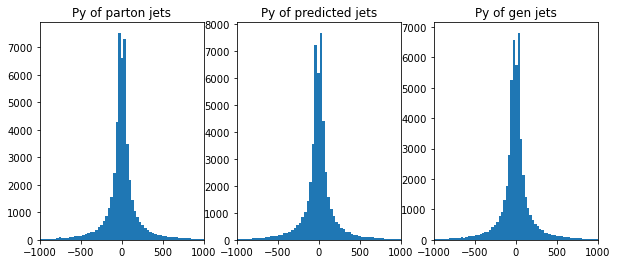

In [19]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 1], bins=200)
ax1.set_title("Py of parton jets")
ax1.set_xlim(-1000, 1000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 1], bins=200)
ax2.set_title("Py of predicted jets")
ax2.set_xlim(-1000, 1000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 1], bins=200)
ax3.set_title("Py of gen jets")
ax3.set_xlim(-1000, 1000)
#plt.yscale('log')
plt.show()

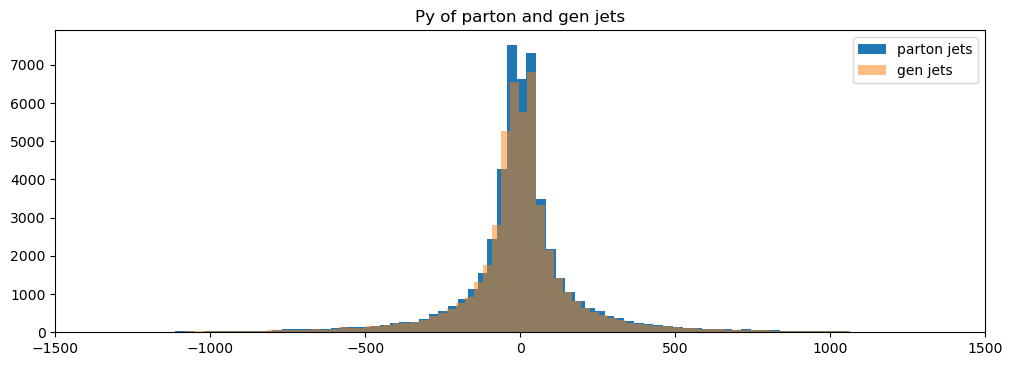

In [20]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 1], bins=200, label='parton jets')
ax1.hist(true[:, 1], bins=200, label='gen jets', alpha=0.5)
ax1.set_title("Py of parton and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

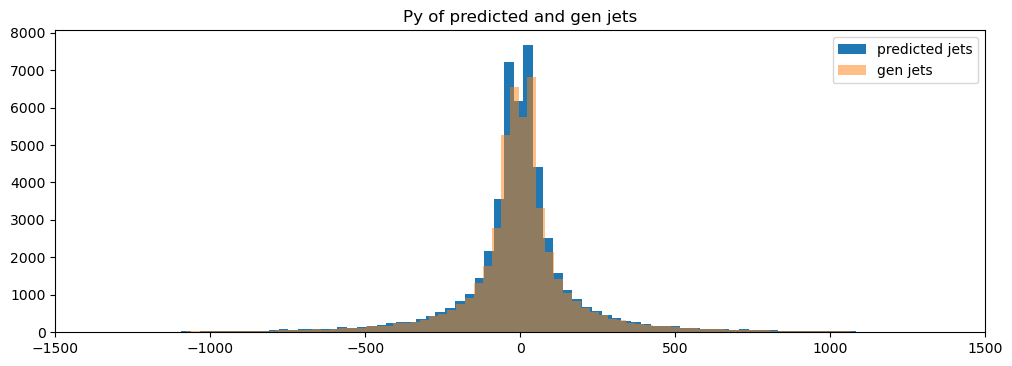

In [21]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 1], bins=200, label='predicted jets')
ax1.hist(true[:, 1], bins=200, label='gen jets', alpha=0.5)
ax1.set_title("Py of predicted and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

## Histograms for Pz

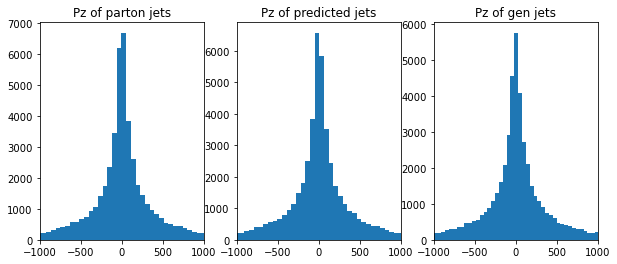

In [22]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 2], bins=200)
ax1.set_title("Pz of parton jets")
ax1.set_xlim(-1000, 1000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 2], bins=200)
ax2.set_title("Pz of predicted jets")
ax2.set_xlim(-1000, 1000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 2], bins=200)
ax3.set_title("Pz of gen jets")
ax3.set_xlim(-1000, 1000)
#plt.yscale('log')
plt.show()

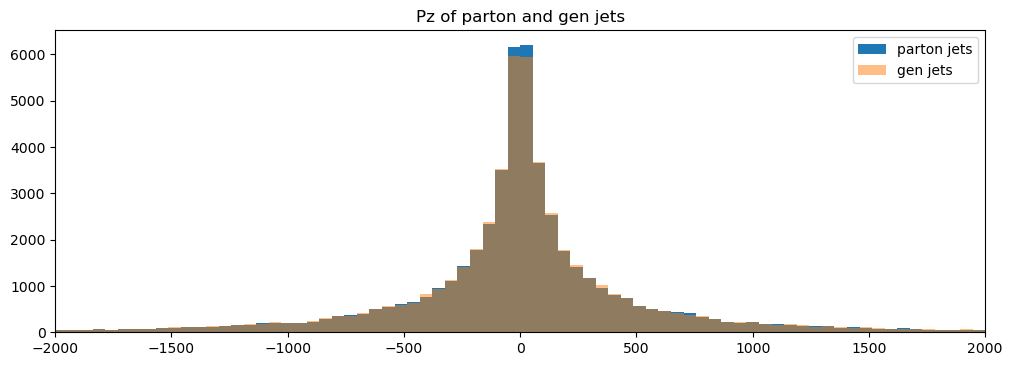

In [23]:
bins = np.linspace(-2000, 2000, 75)
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 2], bins=bins, label='parton jets')
ax1.hist(true[:, 2], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Pz of parton and gen jets")
ax1.set_xlim(-2000, 2000)
ax1.legend()
plt.show()

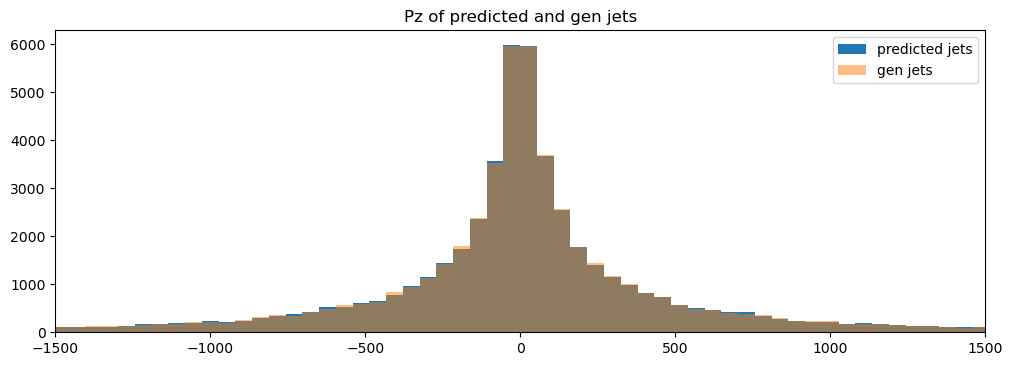

In [24]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 2], bins=bins, label='predicted jets')
ax1.hist(true[:, 2], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Pz of predicted and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

## Energy histograms

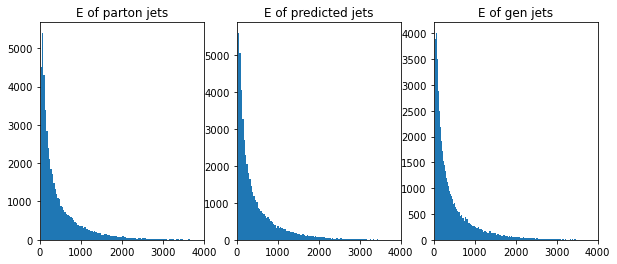

In [25]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 3], bins=200)
ax1.set_title("E of parton jets")
ax1.set_xlim(0, 4000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 3], bins=200)
ax2.set_title("E of predicted jets")
ax2.set_xlim(0, 4000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 3], bins=200)
ax3.set_title("E of gen jets")
ax3.set_xlim(0, 4000)
#plt.yscale('log')
plt.show()

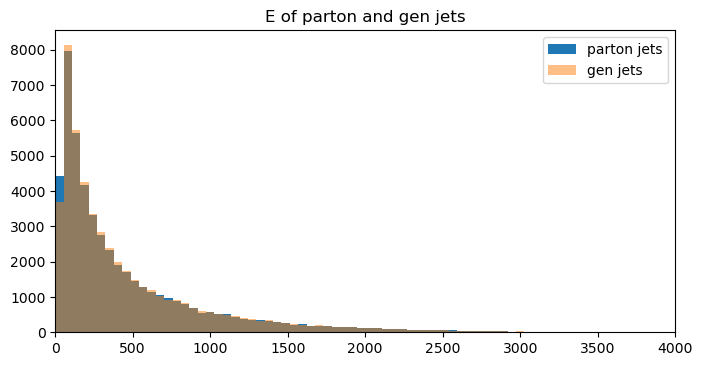

In [26]:
bins = np.linspace(0, 4000, 75)
fig = plt.figure(figsize=(8,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 3], bins=bins, label='parton jets')
ax1.hist(true[:, 3], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("E of parton and gen jets")
ax1.set_xlim(0, 4000)
ax1.legend()
plt.show()

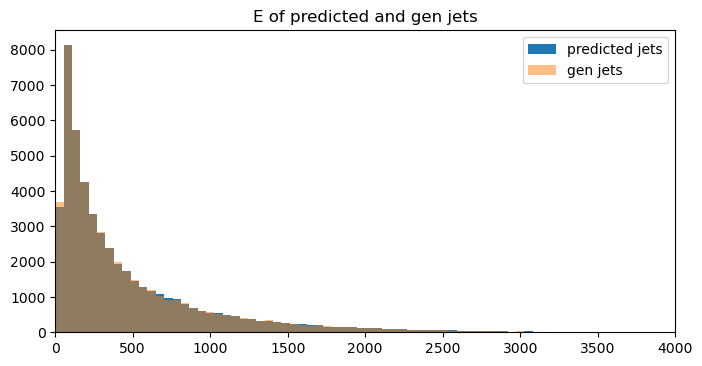

In [27]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 3], bins=bins, label='predicted jets')
ax1.hist(true[:, 3], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("E of predicted and gen jets")
ax1.set_xlim(0, 4000)
ax1.legend()
plt.show()

## Pt histograms

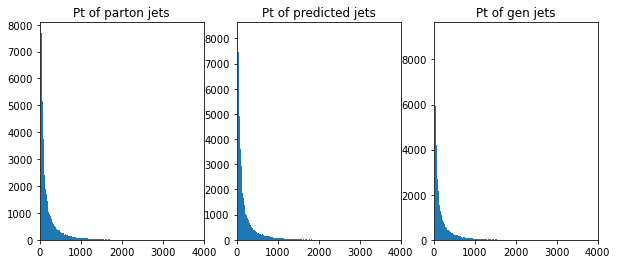

In [28]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(np.sqrt((inputs[:, 0])**2 + (inputs[:, 1])**2), bins=200)
ax1.set_title("Pt of parton jets")
ax1.set_xlim(0, 4000)
ax2 = fig.add_subplot(132)
ax2.hist(np.sqrt((prediction[:, 0])**2 + (prediction[:, 1])**2), bins=200)
ax2.set_title("Pt of predicted jets")
ax2.set_xlim(0, 4000)
ax3 = fig.add_subplot(133)
ax3.hist(np.sqrt((true[:, 0])**2 + (true[:, 1])**2), bins=200)
ax3.set_title("Pt of gen jets")
ax3.set_xlim(0, 4000)
#plt.yscale('log')
plt.show()

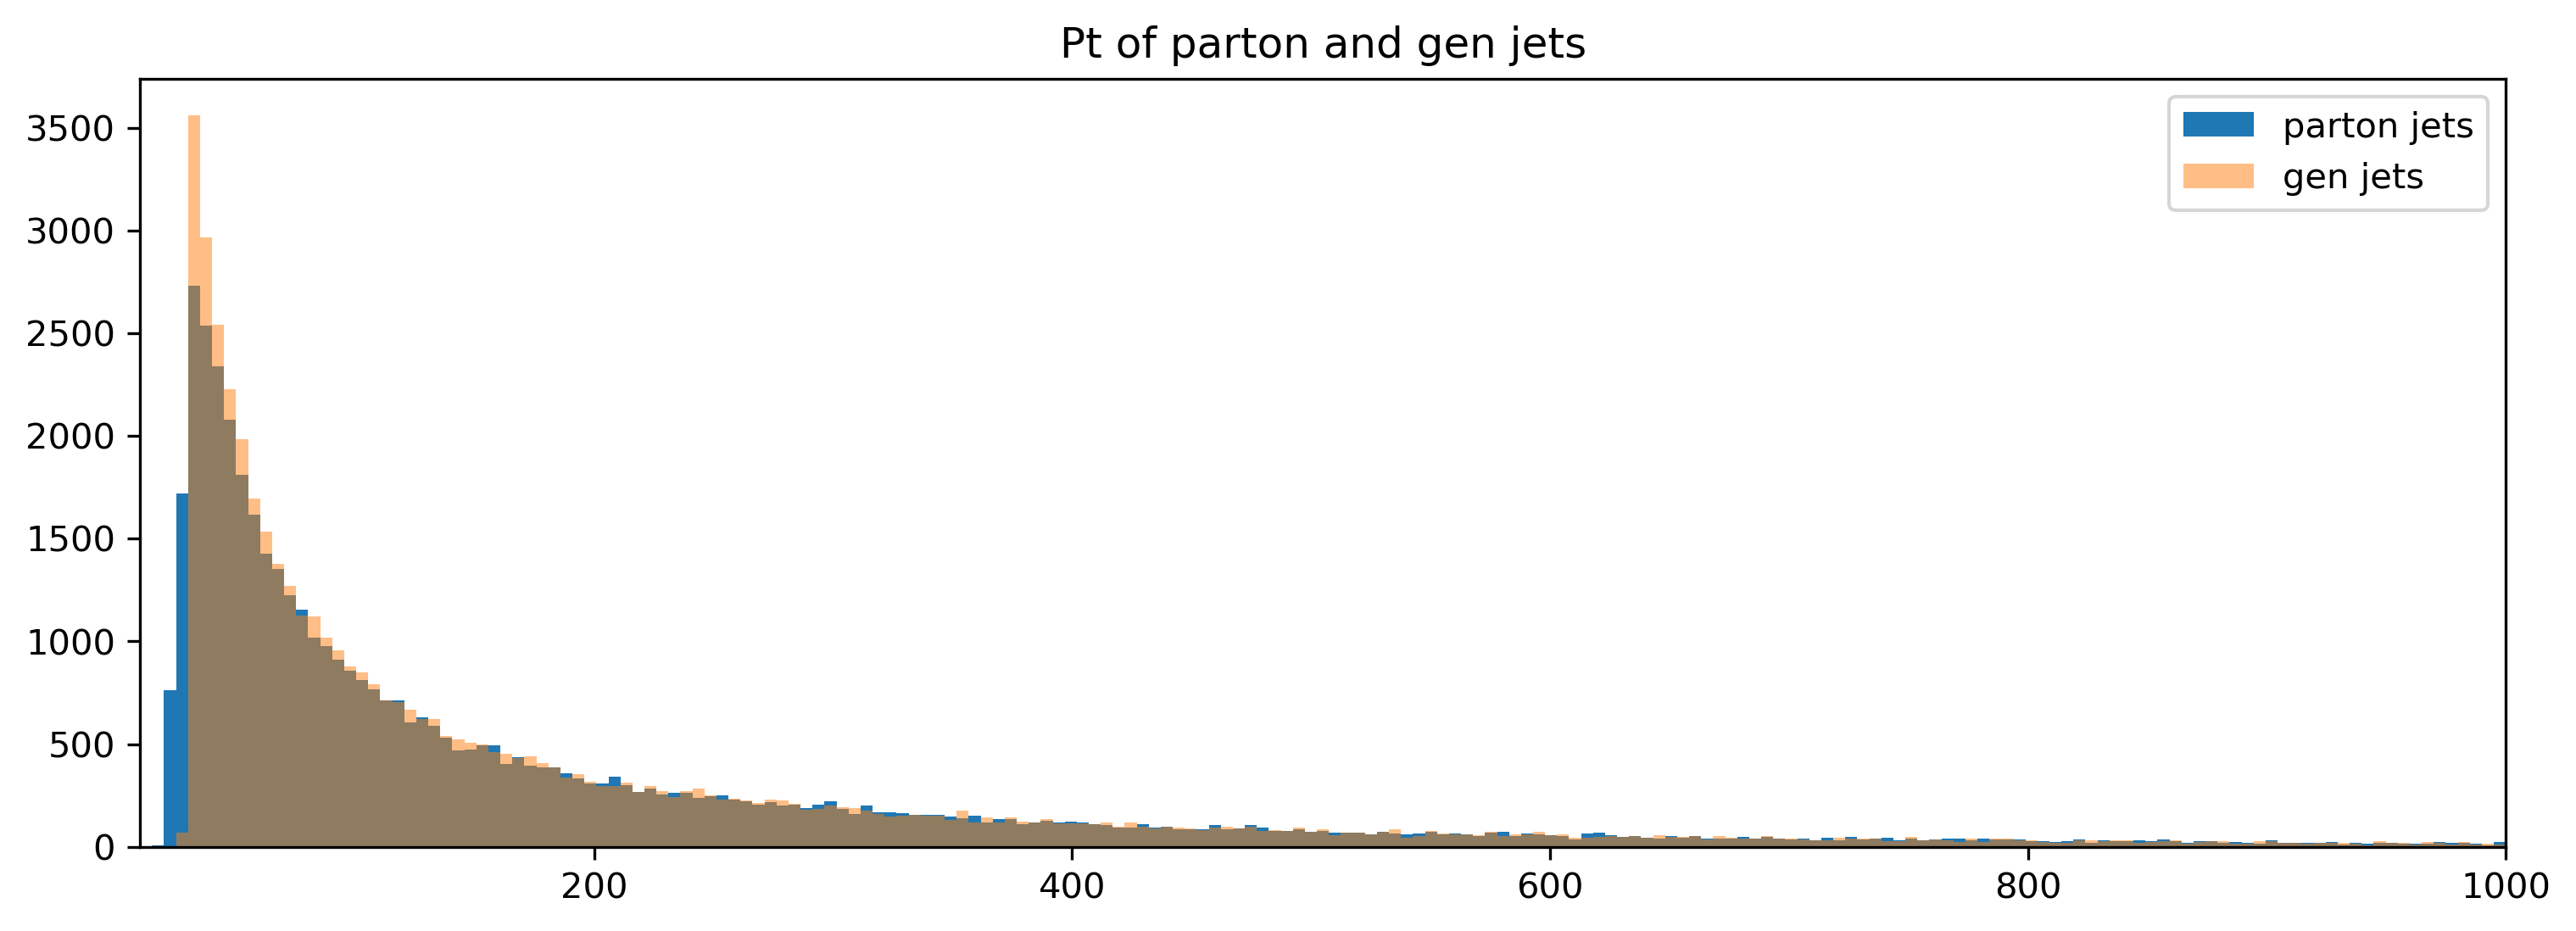

In [36]:
bins_spacing = np.linspace(10, 1000, 198)
fig = plt.figure(figsize=(12,4), dpi=300)
ax1 = fig.add_subplot(111)
ax1.hist(np.sqrt((inputs[:, 0])**2 + (inputs[:, 1])**2), bins=bins_spacing, label='parton jets')
ax1.hist(np.sqrt((true[:, 0])**2 + (true[:, 1])**2), bins=bins_spacing, label='gen jets', alpha=0.5)
ax1.set_title("Pt of parton and gen jets")
ax1.set_xlim(10, 1000)
ax1.legend()
plt.show()

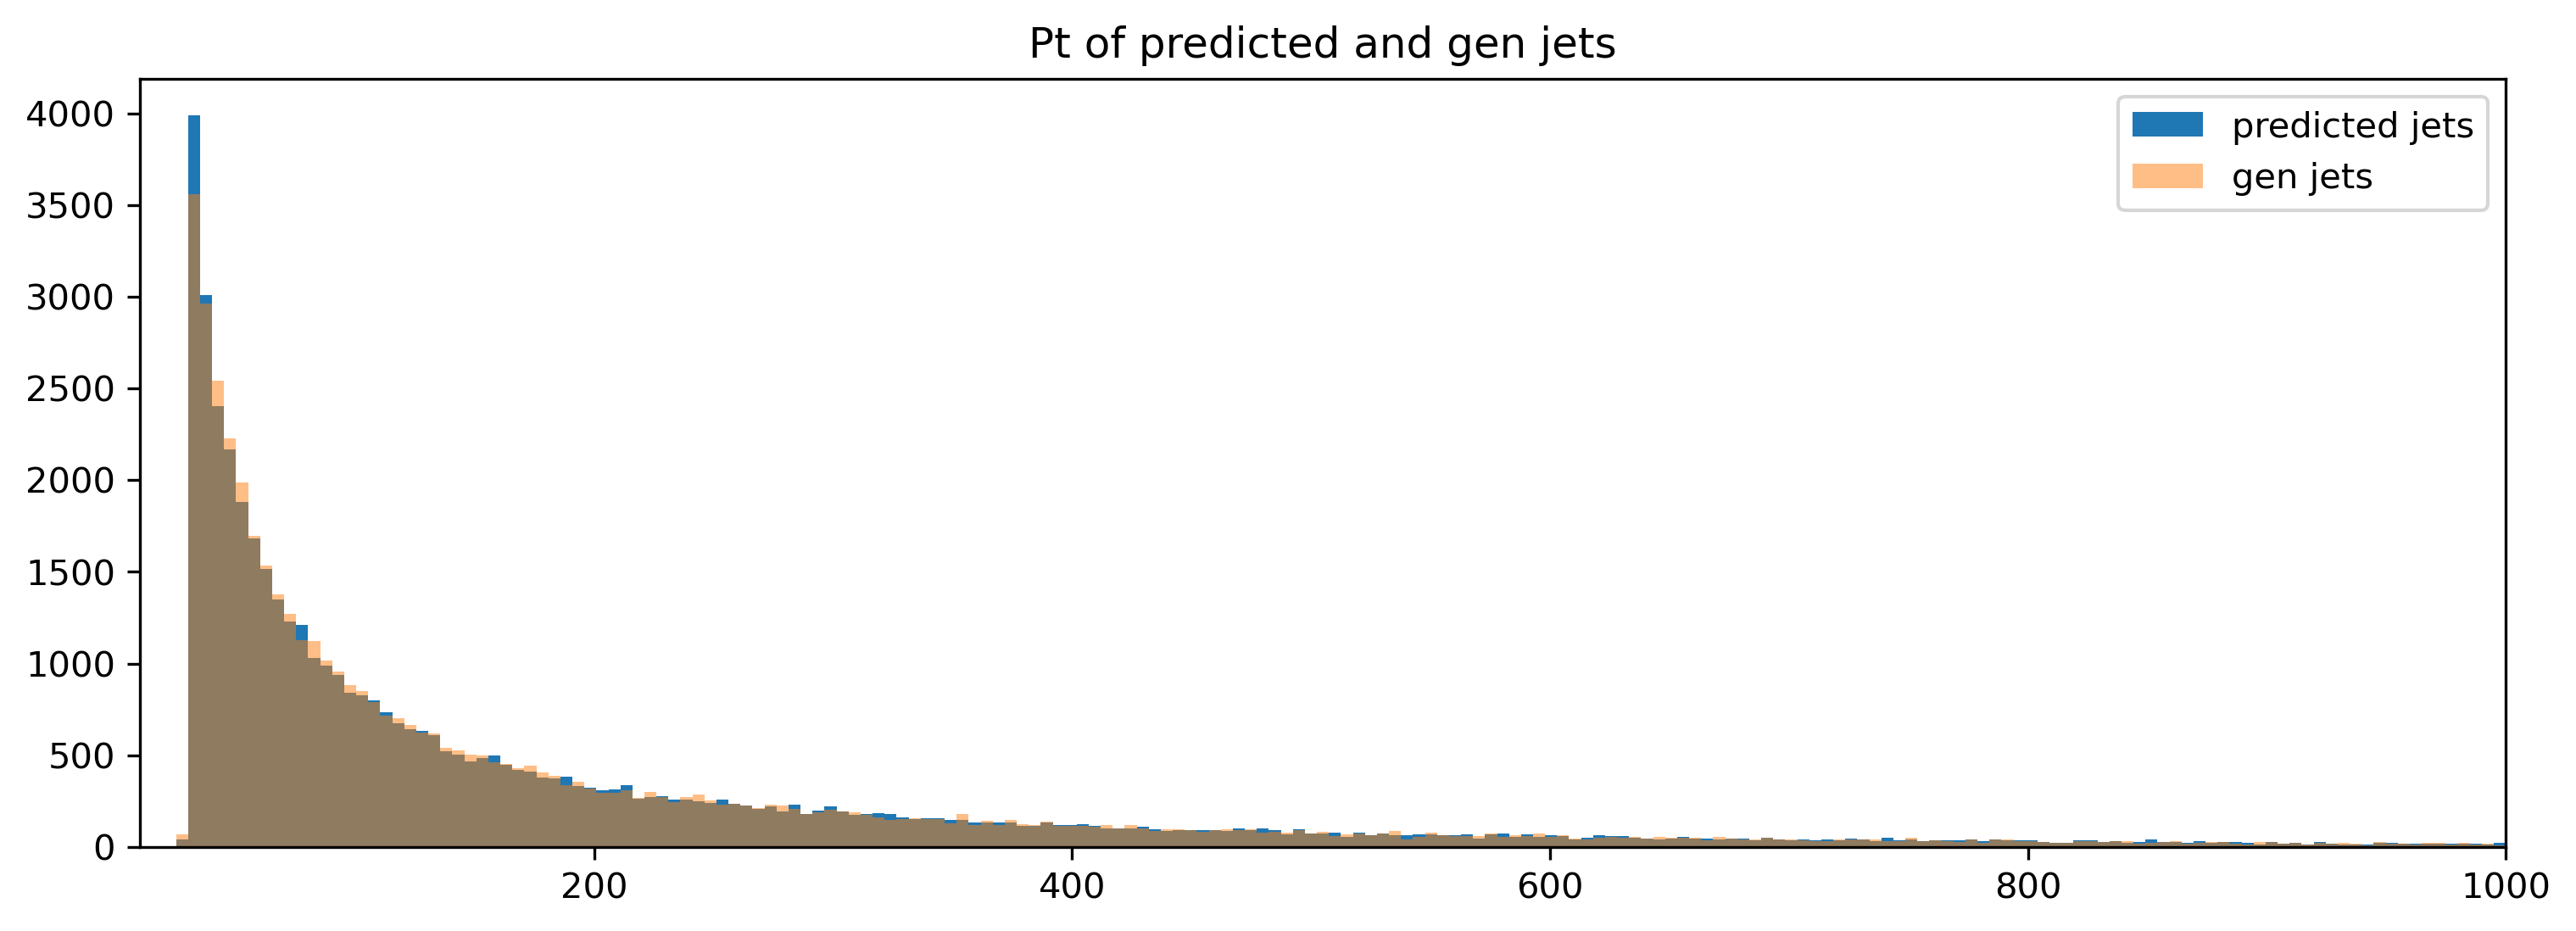

In [38]:
fig = plt.figure(figsize=(12,4), dpi=300)
ax1 = fig.add_subplot(111)
ax1.hist(np.sqrt((prediction[:, 0])**2 + (prediction[:, 1])**2), bins=bins_spacing, label='predicted jets')
ax1.hist(np.sqrt((true[:, 0])**2 + (true[:, 1])**2), bins=bins_spacing, label='gen jets', alpha=0.5)
ax1.set_title("Pt of predicted and gen jets")
ax1.set_xlim(10, 1000)
ax1.legend()
plt.show()

## Calculating delta R

In [31]:
def theta(vec):
    pt = np.sqrt((vec[:, 0])**2 + (vec[:, 1])**2)
    return np.arctan2(pt, vec[:, 2])

def phi(vec):
    return np.arctan2(vec[:, 1], vec[:, 0])

def eta(vec):
    return -np.log(np.tan(theta(vec)/2))

def deltaR(vec1, vec2):
    return (np.sqrt((eta(vec1)-eta(vec2))**2 + (phi(vec1)-phi(vec2))**2))

#testing theta - should return [0.693, 0.549]
arr = np.array(([1, 2, 3, 5],[3, -1, 4, 8]), dtype=float)
print(theta(arr))
print(phi(arr))

[0.64052231 0.66896407]
[ 1.10714872 -0.32175055]


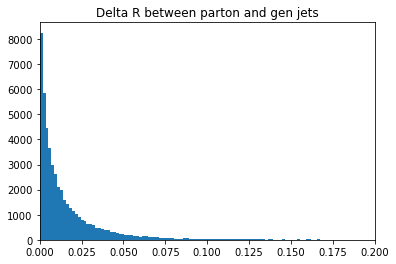

In [134]:
deltaRPartonsGen = ((inputs[:, 1] - true[:, 1])**2 + (inputs[:, 2] - inputs[:, 2])**2)**(1/2)
#print(deltaRPartonsGen.shape)
plt.hist(deltaRPartonsGen, bins=200)
plt.xlim(0,0.2)
plt.title("Delta R between parton and gen jets")
plt.show()

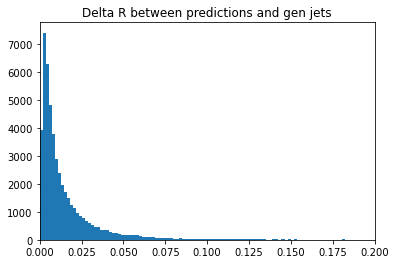

In [135]:
deltaRPredictionGen = ((prediction[:, 1] - true[:, 1])**2 + (prediction[:, 2] - inputs[:, 2])**2)**(1/2)
#print(deltaRPartonsGen.shape)
plt.hist(deltaRPredictionGen, bins=200)
plt.xlim(0,0.2)
plt.title("Delta R between predictions and gen jets")
plt.show()

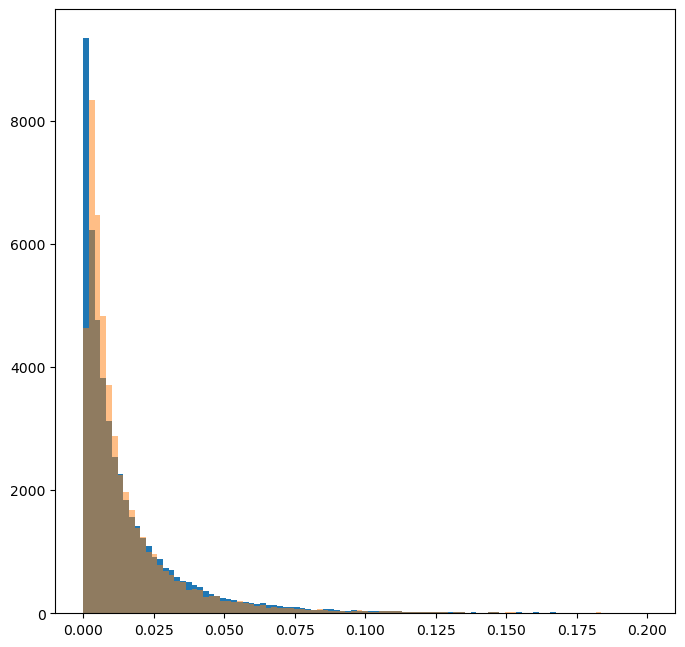

In [142]:
bins = np.linspace(0, 0.2, 100)
fig = plt.figure(figsize=(8,8), dpi=100)
plt.hist(deltaRPartonsGen, bins=bins)
plt.hist(deltaRPredictionGen, bins=bins, alpha=0.5)
plt.show()